In [1]:
import pandas as pd
import sys
import os
from os import listdir
os.chdir("c:/Users/Robert/Documents/Projekte/dev/sport_betting/")
import config as CONFIG
pd.set_option('display.max_columns', 500)

In [2]:
from src.data.provide_data import get_model_data
from src.models.evaluate import custom_classification_report, custom_lazy_report



In [3]:
X_train, y_train = get_model_data(filename = "Train")
X_valid, y_valid = get_model_data(filename = "Valid")
X_test, y_test = get_model_data(filename = "Test")

cat = [X_train.columns.get_loc(i) for i in ["Team","Div","Opponent"]]

Train 5246
Valid 1952
Test 1952


In [4]:
features = X_train.columns

In [5]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler object
scaler = StandardScaler()

# Fit scaler on training data
scaler.fit(X_train)

# Scale training and test data
X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

In [6]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB(alpha=10,binarize=0.5)
bnb.fit(X_train,y=y_train)
y_pred = bnb.predict(X_valid)

In [7]:
import pandas as pd

def get_column_indices(df, column_names):
    """
    Returns the indices of the given column names within the dataframe.
    
    Args:
    - df (pd.DataFrame): the dataframe
    - column_names (list of str): the names of the columns to get indices for
    
    Returns:
    - indices (list of int): the indices of the columns within the dataframe
    """
    indices = []
    for col_name in column_names:
        try:
            indices.append(df.columns.get_loc(col_name))
        except KeyError:
            print(f"Column name '{col_name}' not found in dataframe.")
    return indices


In [8]:
ind  = get_column_indices(df = pd.DataFrame(X_valid,columns=features), column_names = ["B365_Team","B365_Draw","B365_Opponent"])

# Transformer

## Pretrainer

In [ ]:

import torch

from pytorch_tabnet.pretraining import TabNetPretrainer

# Define pretrainer model architecture
pretrainer = TabNetPretrainer(
optimizer_fn=torch.optim.Adam,
optimizer_params=dict(lr=2e-2),
mask_type="entmax"
)

# Train pretrainer model on training data
pretrainer.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=10,
    patience=30,
    pretraining_ratio=0.8,
    batch_size= 64
)


In [12]:
from src.models.loss_function import PrecisionLoss


import torch
from pytorch_tabnet.tab_model import TabNetClassifier
n_d = 8
n_a = 8
n_steps = 3
gamma = 1
lambda_sparse = 0.001
lr = 2e-2
batch_size = 128
max_epochs = 1000
# Define a custom loss function

import torch
import torch.nn as nn

model = TabNetClassifier(n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma, lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=lr), mask_type='entmax', device_name='cuda' if torch.cuda.is_available() else 'cpu')

# Define and train the model with the custom loss function
model.fit(X_train=X_train, y_train=y_train,     eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'], eval_metric=['balanced_accuracy','auc'],batch_size=batch_size, max_epochs=max_epochs, patience=50,loss_fn=PrecisionLoss())


C:\Users\Robert\AppData\Roaming\Python\Python37\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56159 | train_balanced_accuracy: 0.49941 | train_auc: 0.55187 | valid_balanced_accuracy: 0.50787 | valid_auc: 0.54948 |  0:00:01s
epoch 1  | loss: 0.54299 | train_balanced_accuracy: 0.42442 | train_auc: 0.40403 | valid_balanced_accuracy: 0.4657  | valid_auc: 0.46296 |  0:00:03s
epoch 2  | loss: 0.53733 | train_balanced_accuracy: 0.51963 | train_auc: 0.48921 | valid_balanced_accuracy: 0.51512 | valid_auc: 0.49844 |  0:00:05s
epoch 3  | loss: 0.57318 | train_balanced_accuracy: 0.49799 | train_auc: 0.48971 | valid_balanced_accuracy: 0.49572 | valid_auc: 0.45072 |  0:00:08s
epoch 4  | loss: 0.61059 | train_balanced_accuracy: 0.50359 | train_auc: 0.49126 | valid_balanced_accuracy: 0.48204 | valid_auc: 0.50162 |  0:00:10s
epoch 5  | loss: 0.63345 | train_balanced_accuracy: 0.50429 | train_auc: 0.47034 | valid_balanced_accuracy: 0.48706 | valid_auc: 0.47922 |  0:00:12s
epoch 6  | loss: 0.60206 | train_balanced_accuracy: 0.50174 | train_auc: 0.48355 | valid_balanced_accuracy

C:\Users\Robert\AppData\Roaming\Python\Python37\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
n_d = 8
n_a = 8
n_steps = 3
gamma = 1
lambda_sparse = 0.001
lr = 2e-2
batch_size = 128
max_epochs = 1000
# Define a custom loss function

import torch
import torch.nn as nn

from functools import partial

class BetLoss(nn.Module):
    def __init__(self,bets):
        super().__init__()
        self.bets = torch.tensor(bets)
        
    def forward(self, output, target):
        if len(output.shape)>1:
            output = output[:,1]

        output = torch.clamp(output,0,1)>0.5
        target = torch.clamp(target,0,1)>0.5
        # loss = torch.sum(torch.abs(self.X_train_subset) * (torch.abs(target)-torch.abs(output)))/ torch.sum(torch.abs(self.X_train_subset))
        precision = torch.sum((target == True) & (output == True))/output.size(0)
        loss = 1 - precision
        
        
        return loss


ind = [i for i, x in enumerate(features) if x in ["BW_Team"]]

model = TabNetClassifier(n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma, lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=lr), mask_type='entmax', device_name='cuda' if torch.cuda.is_available() else 'cpu')

# Define and train the model with the custom loss function
# Define and train the model with the custom loss function
model.fit(X_train=X_train, y_train=y_train,  eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'], eval_metric=['balanced_accuracy','auc'],batch_size=batch_size, max_epochs=max_epochs, patience=50,loss_fn=BetLoss(bets = X_train[ind]))


In [ ]:
class BetLoss(nn.Module):
    def __init__(self):
        super().__init__()
        

    def forward(self, output, target):
        if len(output.shape) > 1:
            output = output[:, 1]

        correct_predictions = torch.round(torch.clamp(output * target, 0, 1))
        incorrect_predictions = 1 - correct_predictions

        bets_batch = self.bets_tensor[torch.arange(len(incorrect_predictions)), target.long()]
        loss = torch.sum(torch.abs(bets_batch) * torch.abs(incorrect_predictions * output))
        loss /= torch.sum(torch.abs(bets_batch))

        return loss

# create bets_tensor and model as before

model = TabNetClassifier(n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma, lambda_sparse=lambda_sparse,
                          optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=lr), mask_type='entmax',
                          device_name='cuda' if torch.cuda.is_available() else 'cpu')

# Define and train the model with the custom loss function
model.fit(X_train=X_train, y_train=y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],
          eval_name=['train', 'valid'], eval_metric=['balanced_accuracy', 'auc'], batch_size=batch_size,
          max_epochs=max_epochs, patience=50, loss_fn=BetLoss())


## Modellfitting

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

# Define hyperparameters
n_d = 8
n_a = 8
n_steps = 3
gamma = 1
lambda_sparse = 0.001
lr = 2e-2
batch_size = 128
max_epochs = 1000

# Create TabNet classifier
clf = TabNetClassifier(n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma, lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=lr), mask_type='entmax', device_name='cuda' if torch.cuda.is_available() else 'cpu')
# Train TabNet classifier
clf.fit(X_train=bets, y_train=y_train,     eval_set=[(bets, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'], eval_metric=['balanced_accuracy','auc'],batch_size=batch_size, max_epochs=max_epochs, patience=50,loss_fn=simple_loss)
# clf.fit(X_train=X_train, y_train=y_train,     eval_set=[(X_train, y_train), (X_valid, y_valid)],
#     eval_name=['train', 'valid'], eval_metric=['balanced_accuracy','auc'],batch_size=batch_size, max_epochs=max_epochs, patience=50,from_unsupervised=pretrainer,loss_fn=simple_loss)

## Evaluierung

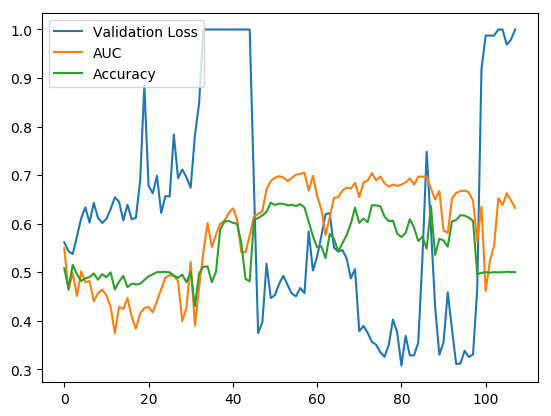

              precision    recall  f1-score   support

       False       0.80      0.48      0.60      1212
        True       0.49      0.80      0.61       740

    accuracy                           0.60      1952
   macro avg       0.64      0.64      0.60      1952
weighted avg       0.68      0.60      0.60      1952



In [13]:
from matplotlib import pyplot as plt
clf = model
plt.plot(clf.history['loss'], label='Validation Loss')
plt.plot(clf.history['valid_auc'], label='AUC')
plt.plot(clf.history['valid_balanced_accuracy'], label='Accuracy')

plt.legend()
plt.show()

from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
r = classification_report(y_pred=y_pred,y_true=y_test)
print(r)

## Erklärbarkeit

In [14]:
import numpy as np
f_i = np.round(pd.Series(clf.feature_importances_),3)
f_i.index = features
f_i.sort_values(ascending=False)

Avg_Draw                             0.393
IW_opponent_odd_pred                 0.178
Min_Draw                             0.118
atHome                               0.116
Team                                 0.108
IW_Draw                              0.086
BW_opponent_odd_pred_last_4_games    0.000
B365_Team_draw_pred                  0.000
IW_Team_last_4_games                 0.000
Avg_Opponent_last_4_games            0.000
Span_Draw                            0.000
Ratio_Draw                           0.000
B365_Team_odd_pred                   0.000
B365_opponent_odd_pred               0.000
IW_Team_odd_pred                     0.000
B365_Team_last_4_games               0.000
B365_Opponent_last_4_games           0.000
IW_Team_draw_pred                    0.000
Ratio_Opponent                       0.000
BW_Team_odd_pred                     0.000
BW_opponent_odd_pred                 0.000
BW_Team_draw_pred                    0.000
Max_Draw                             0.000
Avg_Opponen

In [ ]:
"BW_opponent_odd_pred","B365_Opponent","Avg_Opponent","IW_Team","Span_Draw"      

In [ ]:
sum(f_i>0.01)